# Generation of training and testing data from models
****
- Data source: Dr. Michel Curé and Catalina Arcos, IFA UV
- Each model is stored in a file with a name like: "t4000g20v10.dat", where
 - t is the effective temperature: 4000 [K]
 - g is 10 times the logarithm of the gravity in [cm/seg^2]: 20/10 = 2.0
 - v_rot is the rotational velocity in [km/seg]: 10
 
- For this analysis we will consider:
 - v_rot >= 100
 - t_eff >= 15000
 - wavelength range [4460, 4480]

- Note that the y axis is the normalized flux


## Needed libraries

In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shutil

from sklearn.model_selection import train_test_split

epochs=75
prefijo="v4_5"

text_file = open("../informe1/"+prefijo+"_data.csv", "w")

## Functions

In [2]:
def string2params(string, show=True):
    s1 = string.partition("g")
    t = s1[0][1:]
    s2 = s1[2].partition("v")
    g = s2[0]
    v = s2[-1]
    if show:
        print(s1)
        print("t:",t)
        print(s2)
        print("g: ",float(g)/10)
        print("v:", v)
    return float(t), float(g)/10, float(v)

## Files list

In [3]:
files = glob.glob('../filtered_wv_models/*')
m = len(files)
print("Number of files in models", m)
print("5 first files: \n", files[0:5])


Number of files in models 5425
5 first files: 
 ['../filtered_wv_models\\f_t15000g20v100.dat', '../filtered_wv_models\\f_t15000g20v110.dat', '../filtered_wv_models\\f_t15000g20v120.dat', '../filtered_wv_models\\f_t15000g20v130.dat', '../filtered_wv_models\\f_t15000g20v140.dat']


## Building X an y matrices
*****

In [4]:
print("--> X has dimension", m, " x 201")
print("--> y has diemsnion", m, " x 3")

y = np.zeros((m,3))
df = pd.read_csv(files[0], sep=" ", header=None)
x_points = df[0].values
n_points, n_columns = df.shape
display(df[1].values.shape)
print("Num. of points in x axis: ", n_points)



--> X has dimension 5425  x 201
--> y has diemsnion 5425  x 3


(201,)

Num. of points in x axis:  201


In [5]:
# X matrix contains the spectral lines
X = np.zeros((m,n_points))
# y matrix contains the labels of each spectral line
y = np.zeros((m,3))
for i,name in enumerate(files):
    file_name = name.split("\\")[-1].split(".")[0]
    #print(file_name)
    df = pd.read_csv(name, sep=" ", header=None)
   # print(file_name.split("_")[1])
    t,g,v = string2params(file_name.split("_")[1],False)
    X[i,:] = df[1].values
    y[i] = t,g,v
    #print("----")

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix


# ¿Será necesario normalizar X?
########
#scaler = StandardScaler()
#scaler.fit(X)
#X_s = scaler.transform(X)

# Normalización de los labels
scaler2 = StandardScaler()
scaler2.fit(y)
y_s = scaler2.transform(y)
from joblib import dump, load
dump(scaler2, '../informe1/'+prefijo+'_scaler2.bin', compress=True)


['../informe1/v4_5_scaler2.bin']

## Training, testing and validation sets

In [7]:
def train_val_test_split(X, y, train_size, val_size, test_size, random_state = 1):
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None
    
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = val_size/(test_size + train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y_s, .8, .1, .1)
#X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_s, y_s, .8, .1, .1)

In [9]:
# load numpy array from csv file
from numpy import loadtxt
#X_train = loadtxt('../informe1/X_train.csv', delimiter=';')
#y_train = loadtxt('../informe1/y_train.csv', delimiter=';')
#X_test = loadtxt('../informe1/X_test.csv', delimiter=';')
#y_test = loadtxt('../informe1/y_test.csv', delimiter=';')
#X_val = loadtxt('../informe1/X_val.csv', delimiter=';')
#y_val = loadtxt('../informe1/y_val.csv', delimiter=';')

from numpy import savetxt
#savetxt('../informe1/X_train.csv', X_train, delimiter=';')
#savetxt('../informe1/y_train.csv', y_train, delimiter=';')
#savetxt('../informe1/X_test.csv', X_test, delimiter=';')
#savetxt('../informe1/y_test.csv', y_test, delimiter=';')
#savetxt('../informe1/X_val.csv', X_val, delimiter=';')
#savetxt('../informe1/y_val.csv', y_val, delimiter=';')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)
print("ytest[0]:",y_test[0])
#print("X_train[0]: ",X_train[0]);

(4339, 201) (4339, 3)
(543, 201) (543, 3)
(543, 201) (543, 3)
ytest[0]: [-1.24807544  0.          0.4472136 ]


# Convolutional neural network

In [10]:
# about activation functions: https://datascience.stackexchange.com/questions/47751/what-activation-function-should-i-use-for-a-specific-regression-problem

In [11]:
# https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing#scrollTo=ud_tq1A0Ffvl

time_steps = X.shape[1]
input_dimension = 1
sample_size = X_train.shape[0]
print("sample_size:",sample_size,"time_steps: ",time_steps,"input_dimension: ",input_dimension)

sample_size: 4339 time_steps:  201 input_dimension:  1


In [12]:
sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [13]:
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)
print("X_train_reshaped[0]: ",X_train_reshaped[0]);

(4339, 201, 1)
(543, 201, 1)
(543, 201, 1)
X_train_reshaped[0]:  [[0.9991277]
 [0.9991139]
 [0.9990969]
 [0.9990771]
 [0.9990589]
 [0.9990421]
 [0.9990269]
 [0.999013 ]
 [0.9990005]
 [0.9989894]
 [0.9989796]
 [0.9989712]
 [0.9989641]
 [0.9989584]
 [0.998954 ]
 [0.9989508]
 [0.998949 ]
 [0.9989485]
 [0.9989713]
 [0.9990106]
 [0.9990635]
 [0.9991286]
 [0.9991828]
 [0.9992322]
 [0.999277 ]
 [0.9993187]
 [0.9993583]
 [0.999396 ]
 [0.9994324]
 [0.9994632]
 [0.9994811]
 [0.9994831]
 [0.9994772]
 [0.9994727]
 [0.9994717]
 [0.9994745]
 [0.9994796]
 [0.9994865]
 [0.999495 ]
 [0.9995051]
 [0.9995144]
 [0.9995215]
 [0.9995299]
 [0.9995438]
 [0.9995845]
 [0.9996454]
 [0.9996995]
 [0.9997504]
 [0.9997949]
 [0.9998433]
 [0.999898 ]
 [0.9999782]
 [1.000043 ]
 [1.000085 ]
 [1.000102 ]
 [1.000104 ]
 [1.000096 ]
 [1.00008  ]
 [1.000066 ]
 [1.000056 ]
 [1.000047 ]
 [1.000031 ]
 [1.000002 ]
 [0.9999605]
 [0.9999073]
 [0.999842 ]
 [0.9997619]
 [0.9996651]
 [0.99955  ]
 [0.9994135]
 [0.9992456]
 [0.9990381]

# Histograms
*****


In [14]:
def histograms_params(train, test, val, bins, labels, title=None):
    plt.figure()
    plt.hist(train, bins='auto', label=labels[0])
    if val is not None:
        plt.hist(val, bins='auto', label=labels[1])
    if test is not None:
        plt.hist(test, bins='auto', label=labels[2], alpha=0.3)
    
    if title is not None:
        plt.title(title)
    plt.legend(loc="best")
    plt.show()
    
def plot_params(X,train, labels, title=None):
    plt.figure()
    plt.plot(X,train)
    
    if title is not None:
        plt.title(title)
    plt.legend(loc="best")
    plt.show()    
    

#import seaborn as sns
#sns.set_theme(style="whitegrid")


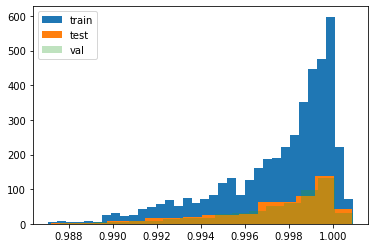

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


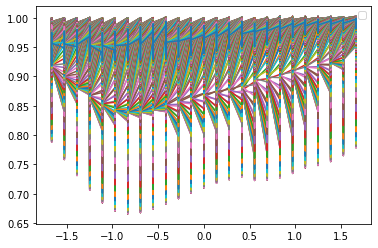

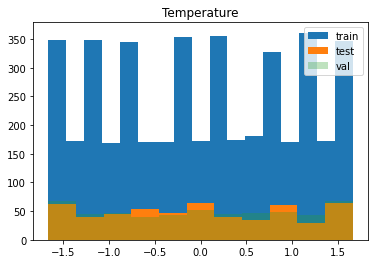

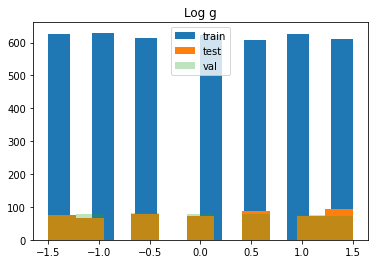

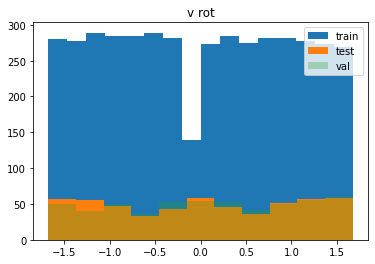

In [15]:
histograms_params(X_train[:,0], X_val[:,0], X_test[:,0], 0, ["train", "test", "val"])
plot_params(y_s[:,0],X, ["train", "test", "val"])

histograms_params(y_train[:,0], y_val[:,0], y_test[:,0], 0, ["train", "test", "val"],"Temperature")
histograms_params(y_train[:,1], y_val[:,1], y_test[:,1], 0, ["train", "test", "val"], "Log g")
histograms_params(y_train[:,2], y_val[:,2], y_test[:,2], 0, ["train", "test", "val"], "v rot")

In [16]:
import tensorflow as tf
import keras

### Optimizar los parámetros de esta red
***
- Puede cambiar la arquitectura, agregando o quitando capas, modificando las funciones de activación, cambiando la función de pérdida, etc.

In [17]:
def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #201
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=256, kernel_size=14, activation='swish', name="Conv1D_1"))
    
    #se agrega
    model.add(keras.layers.Conv1D(filters=512, kernel_size=7, activation='swish', name="Conv1D_2"))
    model.add(keras.layers.Conv1D(filters=256, kernel_size=7, activation='swish', name="Conv1D_3"))
    model.add(keras.layers.Conv1D(filters=128, kernel_size=7, activation='swish', name="Conv1D_4"))    
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='swish', name="Conv1D_5"))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='swish', name="Conv1D_6")) #se subio a 7 kernel
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='swish', name="Conv1D_7"))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='swish', name="Conv1D_8"))
    
    tf.keras.layers.BatchNormalization()
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    #se agregan
    model.add(keras.layers.Dense(16, activation= "selu", name="Dense_2"))
    model.add(keras.layers.Dense(8, activation= "selu", name="Dense_3"))
    model.add(keras.layers.Dense(3, activation = "linear", name="Dense_4"))
    
    learningRate = 0.001    
    text_file.write("\nLearning rate;"+str(learningRate).replace(".",","))
    optimizer = tf.keras.optimizers.RMSprop(learningRate)

    l = tf.keras.losses.LogCosh()
    lossFunction = "log_cosh"
    
    text_file.write("\nloss function;"+str(lossFunction).replace(".",","))
    
    model.compile(loss=lossFunction,optimizer=optimizer,metrics=[lossFunction,'accuracy'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()
nlayers = len(model_conv1D.layers)
print("Layers: ",nlayers)
print("Epocs:",epochs)
text_file.write("\nCapas;"+str(nlayers).replace(".",","))
text_file.write("\nEpoch;"+str(epochs).replace(".",","))
text_file.write("\nParametros;"+str(model_conv1D.count_params()).replace(".",","))


Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 188, 256)          3840      
                                                                 
 Conv1D_2 (Conv1D)           (None, 182, 512)          918016    
                                                                 
 Conv1D_3 (Conv1D)           (None, 176, 256)          917760    
                                                                 
 Conv1D_4 (Conv1D)           (None, 170, 128)          229504    
                                                                 
 Conv1D_5 (Conv1D)           (None, 164, 64)           57408     
                                                                 
 Conv1D_6 (Conv1D)           (None, 158, 64)           28736     
                                                                 
 Conv1D_7 (Conv1D)           (None, 156, 32)          

19

In [18]:
ep = epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                patience=ep)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=ep,
                    validation_data = (X_val_reshaped, y_val), 
                           verbose=1, callbacks=[callback])



Epoch 1/75
136/136 [==============================] - 33s 235ms/step - loss: 0.8676 - log_cosh: 0.8676 - accuracy: 0.3436 - val_loss: 0.3973 - val_log_cosh: 0.3973 - val_accuracy: 0.3223
Epoch 2/75
136/136 [==============================] - 32s 233ms/step - loss: 0.5935 - log_cosh: 0.5935 - accuracy: 0.3459 - val_loss: 0.4159 - val_log_cosh: 0.4159 - val_accuracy: 0.3039
Epoch 3/75
136/136 [==============================] - 33s 243ms/step - loss: 0.4461 - log_cosh: 0.4461 - accuracy: 0.3872 - val_loss: 0.3535 - val_log_cosh: 0.3535 - val_accuracy: 0.5672
Epoch 4/75
136/136 [==============================] - 32s 237ms/step - loss: 0.4024 - log_cosh: 0.4024 - accuracy: 0.4496 - val_loss: 0.3218 - val_log_cosh: 0.3218 - val_accuracy: 0.5470
Epoch 5/75
136/136 [==============================] - 32s 233ms/step - loss: 0.3587 - log_cosh: 0.3587 - accuracy: 0.5303 - val_loss: 0.2995 - val_log_cosh: 0.2995 - val_accuracy: 0.5249
Epoch 6/75
136/136 [==============================] - 33s 242ms/s

Epoch 45/75
136/136 [==============================] - 32s 232ms/step - loss: 0.0303 - log_cosh: 0.0303 - accuracy: 0.9189 - val_loss: 0.0327 - val_log_cosh: 0.0327 - val_accuracy: 0.9227
Epoch 46/75
136/136 [==============================] - 32s 238ms/step - loss: 0.0303 - log_cosh: 0.0303 - accuracy: 0.9209 - val_loss: 0.0288 - val_log_cosh: 0.0288 - val_accuracy: 0.9245
Epoch 47/75
136/136 [==============================] - 31s 228ms/step - loss: 0.0306 - log_cosh: 0.0306 - accuracy: 0.9239 - val_loss: 0.0363 - val_log_cosh: 0.0363 - val_accuracy: 0.9116
Epoch 48/75
136/136 [==============================] - 31s 231ms/step - loss: 0.0317 - log_cosh: 0.0317 - accuracy: 0.9163 - val_loss: 0.0332 - val_log_cosh: 0.0332 - val_accuracy: 0.9208
Epoch 49/75
136/136 [==============================] - 31s 229ms/step - loss: 0.0302 - log_cosh: 0.0302 - accuracy: 0.9258 - val_loss: 0.0361 - val_log_cosh: 0.0361 - val_accuracy: 0.9190
Epoch 50/75
136/136 [==============================] - 31s 2

Saved model_conv1D to disk:  ../informe1/v4_5_model_conv1D_e75_l13.h5
[0.03357868641614914, 0.03357868641614914, 0.9116021990776062]
Testing set Mean Abs Error: 33,57868641614914
17/17 [==============================] - 1s 58ms/step


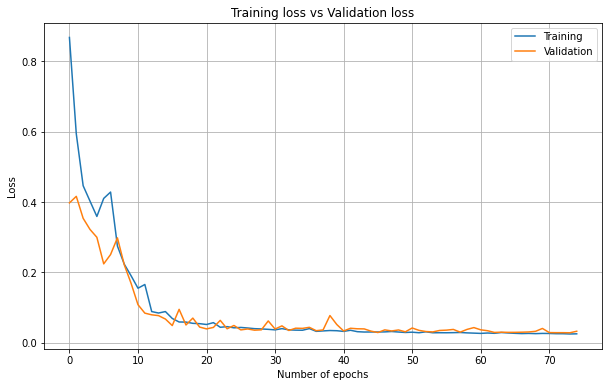

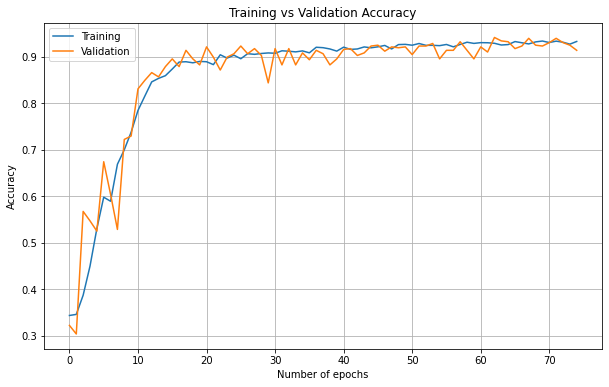

In [19]:
model_conv1D.save("../informe1/"+prefijo+"_model_conv1D_e"+str(epochs)+"_l"+str(nlayers)+".h5")
print("Saved model_conv1D to disk: ","../informe1/"+prefijo+"_model_conv1D_e"+str(epochs)+"_l"+str(nlayers)+".h5")
print(model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0))
[loss, mae,accuracy] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: "+str(mae * 1000).replace(".",","))
text_file.write("\nTesting Mean Abs Error;"+str(mae * 1000).replace(".",","))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = scaler2.inverse_transform(y)


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])
    plt.savefig("../informe1/"+prefijo+"_loss_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
    #plt.savefig("../informe1/loss_e"+str(epochs)+"_l"+str(nlayers)+".jpg") #save as png
    plt.show()

plot_train_val(train_loss, val_loss, ep, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')
plot_train_val(train_acc, val_acc, ep, 'Accuracy', 'Number of epochs', 'Training vs Validation Accuracy')




In [20]:
from sklearn.metrics import mean_absolute_error

(543,)
(543,)


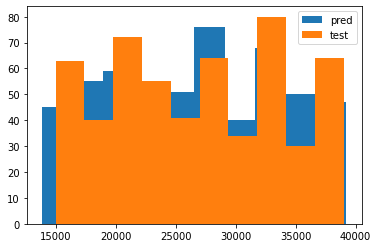

In [21]:
a = scaler2.inverse_transform(pred)
print(a[:,0].shape)


b = scaler2.inverse_transform(y_test)
print(b[:,0].shape)

plt.figure()
plt.hist(a[:,0], label="pred")
plt.hist(b[:,0], label="test")

plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_pre_vs_test_temperatura_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()





In [22]:
pred[:,0].shape

(543,)

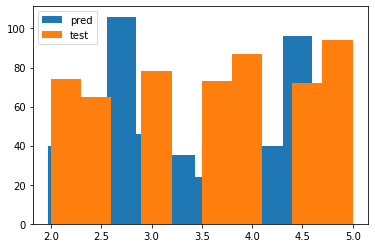

In [23]:
plt.figure()
plt.hist(a[:,1], label="pred")
plt.hist(b[:,1], label="test")

plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_pred_vs_test_logg_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()



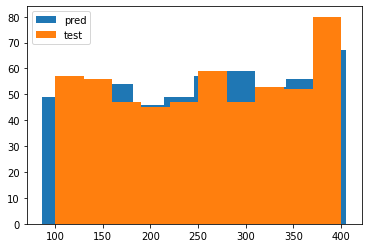

In [24]:

plt.figure()
plt.hist(a[:,2], label="pred")
plt.hist(b[:,2], label="test")

plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_pred_vs_test_velocidad_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()



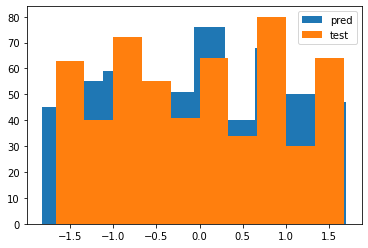

In [25]:
plt.figure()
plt.hist(pred[:,0], label="pred")
plt.hist(y_test[:,0], label="test")

plt.legend(loc="best")
plt.show()


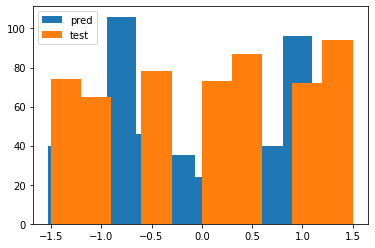

In [26]:
plt.figure()
plt.hist(pred[:,1], label="pred")
plt.hist(y_test[:,1], label="test")

plt.legend(loc="best")
plt.show()

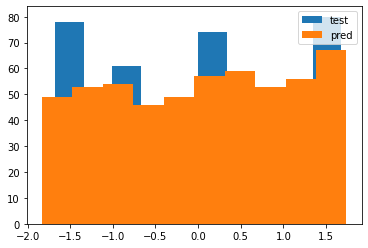

In [27]:
plt.figure()
plt.hist(y_test[:,2], label="test")
plt.hist(pred[:,2], label="pred")
plt.legend(loc="best")
plt.show()

In [28]:
mn = mean_absolute_error(pred, y_test)
print("Mean Absolute Error(nomalizado)=",mn)
text_file.write("\nMean Absolute Error(nomalizado);"+str(mn).replace(".",","))
#mean_absolute_error(a, b)
m = mean_absolute_error(a, b)
#tf.keras.metrics.max_error(a,b)
#MeanRelativeError
print("Mean Absolute Error=",m)
text_file.write("\nMean Absolute Error;"+str(m).replace(".",","))
rel_error = 2 * np.absolute(pred - y_test) / (np.absolute(pred) + np.absolute(y_test))
print("Error relativo normalizado: ",f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%")
text_file.write("\nError relativo normalizado;"+f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%".replace(".",","))
rel_error = 2 * np.absolute(a - b) / (np.absolute(a) + np.absolute(b))
print("Error relativo desnormalizado: ",f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%")

text_file.write("\nError relativo desnormalizado;"+f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%".replace(".",","))


Mean Absolute Error(nomalizado)= 0.1687891332322454
Mean Absolute Error= 249.82560809694823
Error relativo normalizado:  36.5% +/- 55.69%
Error relativo desnormalizado:  5.38% +/- 7.02%


46

In [29]:
e_teff = abs(y_test[:,0] - pred[:,0])
e_logg = abs(y_test[:,1] - pred[:,1])
e_vrot = abs(y_test[:,2] - pred[:,2])

0.10325188534514315
Error relativo desnormalizado temperatura:  2.89% +/- 2.67%
Error relativo desnormalizado logg:  11.1% +/- 9.36%
Error relativo desnormalizado velocidad:  2.15% +/- 1.99%


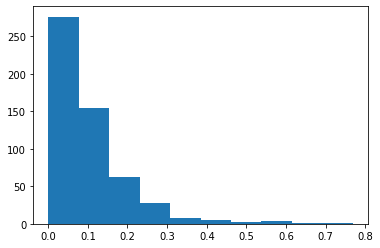

In [30]:
print(e_teff.mean())
rel_error = 2 * np.absolute(a[:,0]- b[:,0]) / (np.absolute(a[:,0]) + np.absolute(b[:,0]))
print("Error relativo desnormalizado temperatura: ",f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%")
text_file.write("\nError relativo desnormalizado temperatura;"+f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%".replace(".",","))
rel_error = 2 * np.absolute(a[:,1]- b[:,1]) / (np.absolute(a[:,1]) + np.absolute(b[:,1]))
print("Error relativo desnormalizado logg: ",f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%")
text_file.write("\nError relativo desnormalizado logg;"+f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%".replace(".",","))
rel_error = 2 * np.absolute(a[:,2]- b[:,2]) / (np.absolute(a[:,2]) + np.absolute(b[:,2]))
print("Error relativo desnormalizado velocidad: ",f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%")
text_file.write("\nError relativo desnormalizado velocidad;"+f"{round(rel_error.mean() * 100, 2)}% +/- {round(rel_error.std() * 100, 2)}%".replace(".",","))



plt.figure()
plt.hist(e_teff)
plt.show()

0.35207998387611594


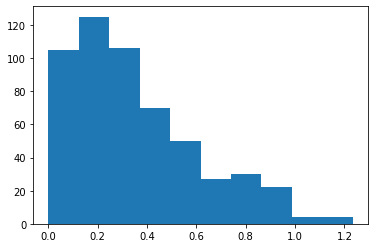

In [31]:
print(e_logg.mean())

plt.figure()
plt.hist(e_logg)
plt.show()

0.051035530475477035


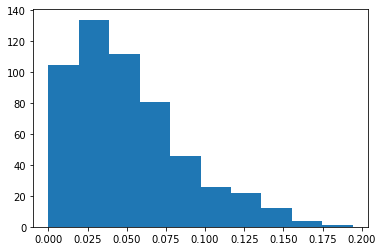

In [32]:
print(e_vrot.mean())

plt.figure()
plt.hist(e_vrot)
plt.show()

# BeSoS lines

In [33]:
df = pd.read_csv("../HD35411-BESOS/HD35411_2015-02-25_01-36-00_final_corr.txt", sep="\t", header=None)
#df = pd.read_csv("../filtered_wv_models/f_t15000g20v140.dat", sep=" ", header=None)

m1 = df[0] >= 4460
m2 = df[0] <= 4480

df2 = df[m1][m2]

df2

C:\Users\claud\AppData\Local\Temp\ipykernel_25364\4139545611.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[m1][m2]


,0,1
2369,4460.017173,0.978701
2370,4460.106507,1.024083
2371,4460.195840,1.054551
2372,4460.285173,1.037242
2373,4460.374506,0.995095
...,...,...
2588,4479.581150,0.971979
2589,4479.670483,0.957869
2590,4479.759816,0.954362
2591,4479.849150,0.968432


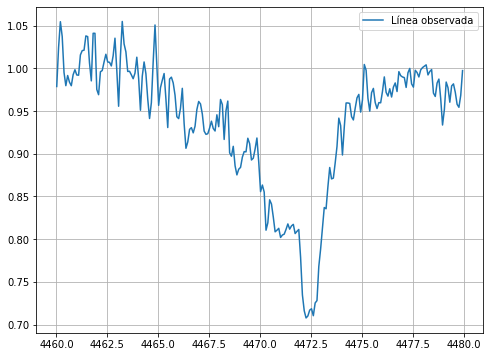

In [34]:
plt.figure(figsize=(8,6))
plt.plot(df2[0], df2[1], label="Línea observada")
#plt.plot(df4[0], df4[1], label="Modelo")
plt.grid()
plt.legend(loc="best")
plt.show()

In [35]:
n = 201  # for 2 random indices
index = np.random.choice(df2[0].shape[0], n, replace=False) 

In [36]:
index.sort()
index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  59,  60,  61,  64,  65,  66,  67,  68,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127,
       128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169,
       171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 190, 191, 193, 194, 195, 196, 197, 198, 19

In [37]:
obs_waves = df2[0].values[index]

obs_flux = df2[1].values[index]

from numpy import savetxt
savetxt('../informe1/'+prefijo+'_obs_waves.csv', obs_waves, delimiter=';')
savetxt('../informe1/'+prefijo+'_obs_flux.csv', obs_flux, delimiter=';')

In [38]:
obs_flux.shape

(201,)

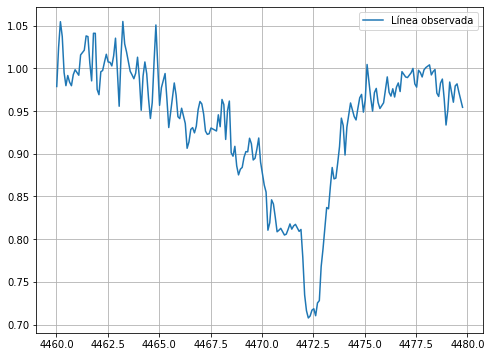

In [39]:
plt.figure(figsize=(8,6))
plt.plot(obs_waves, obs_flux ,label="Línea observada")
plt.grid()
plt.legend(loc="best")
plt.show()

In [40]:
#obs_x_reshaped = x_obs_inv.reshape((1, time_steps, input_dimension))
#obs_x_reshaped = obs_x.reshape((1, time_steps, input_dimension))

obs_flux_reshaped = obs_flux.reshape((1, time_steps, input_dimension))

In [41]:

pred_obs =model_conv1D.predict(obs_flux_reshaped)

1/1 [==============================] - 0s 22ms/step


In [42]:
# Acá los resultados es con los datos normalizados
print("t_eff:", pred_obs[0][0])
print("log g:", pred_obs[0][1])
print("v_rot:", pred_obs[0][2])
text_file.write("\nt_eff;"+str(pred_obs[0][0]).replace(".",","))
text_file.write("\nlog g;"+str(pred_obs[0][1]).replace(".",","))
text_file.write("\nv_rot;"+str(pred_obs[0][2]).replace(".",","))

t_eff: -1.265806
log g: -0.37327462
v_rot: -0.40696603


18

## "Desnormalización de la predicción"

In [43]:
pred_obs_inv = scaler2.inverse_transform(pred_obs)

In [44]:
pred_obs_inv

array([[1.7872145e+04, 3.1267254e+00, 2.1359985e+02]], dtype=float32)

In [45]:
print(pred_obs_inv[0,0])
print(pred_obs_inv[0,1])
print(pred_obs_inv[0,2])
text_file.write("\nDesnormalizada; ")
text_file.write("\nt_eff;"+str(pred_obs_inv[0][0]).replace(".",","))
text_file.write("\nlog g;"+str(pred_obs_inv[0][1]).replace(".",","))
text_file.write("\nv_rot;"+str(pred_obs_inv[0][2]).replace(".",","))

17872.145
3.1267254
213.59985


16

In [46]:
import warnings
warnings.simplefilter("ignore")
ncorridas=1000
res0=[0 for i in range(ncorridas)]
res1=[0 for i in range(ncorridas)]
res2=[0 for i in range(ncorridas)]
for i in range(ncorridas):
    
    df = pd.read_csv("../HD35411-BESOS/HD35411_2015-02-25_01-36-00_final_corr.txt", sep="\t", header=None)
    m1 = df[0] >= 4460
    m2 = df[0] <= 4480
    df2 = df[m1][m2]
    
   # df2=df_in
    n = 201  # for 2 random indices
    index = np.random.choice(df2[0].shape[0], n, replace=False) 
    index.sort()
    obs_waves = df2[0].values[index]
    #print("datos normalizados 1 ",i)
    obs_flux = df2[1].values[index]
    obs_flux.shape
    obs_flux_reshaped = obs_flux.reshape((1, time_steps, input_dimension))
    pred_obs =model_conv1D.predict(obs_flux_reshaped)
    #print("datos normalizados ",i)
    # Acá los resultados es con los datos normalizados
    #print("t_eff:", pred_obs[0][0])
    #print("log g:", pred_obs[0][1])
    #print("v_rot:", pred_obs[0][2])
    pred_obs_inv = scaler2.inverse_transform(pred_obs)
    #pred_obs_inv
    #print("datos normalizados ",i)
    # Acá los resultados es con los datos des-normalizados
    #print("t_eff:",pred_obs_inv[0,0])
    #print("log g:",pred_obs_inv[0,1])
    #print("v_rot:",pred_obs_inv[0,2])
    res0[i]=pred_obs_inv[0,0]
    res1[i]=pred_obs_inv[0,1]
    res2[i]=pred_obs_inv[0,2]
    
warnings.resetwarnings()

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


In [47]:
#print(res0)   
import statistics
print("Repeticiones: ",ncorridas)
text_file.write("\nRepeticiones;"+str(ncorridas).replace(".",","))
mean = statistics.mean(res0)
dev = statistics.stdev(res0)
mediana = statistics.median(res0)
moda = statistics.mode(res0)
print("data temperatura:")
print(mean)
print(dev)
print(mediana)
print(moda)
text_file.write("\ndata temperatura; ")
text_file.write("\nmedia;"+str(mean).replace(".",","))
text_file.write("\ndev;"+str(dev).replace(".",","))
text_file.write("\nmediana;"+str(mediana).replace(".",","))
text_file.write("\nmoda;"+str(moda).replace(".",","))
mean = statistics.mean(res1)
dev = statistics.stdev(res1)
mediana = statistics.median(res1)
moda = statistics.mode(res1)
print("data log g:")
print(mean)
print(dev)
print(mediana)
print(moda)
text_file.write("\ndata logg; ")
text_file.write("\nmedia;"+str(mean).replace(".",","))
text_file.write("\ndev;"+str(dev).replace(".",","))
text_file.write("\nmediana;"+str(mediana).replace(".",","))
text_file.write("\nmoda;"+str(moda).replace(".",","))
mean = statistics.mean(res2)
dev = statistics.stdev(res2)
mediana = statistics.median(res2)
moda = statistics.mode(res2)
print("data velocidad:")
print(mean)
print(dev)
print(mediana)
print(moda)
text_file.write("\ndata velocidad; ")
text_file.write("\nmedia;"+str(mean).replace(".",","))
text_file.write("\ndev;"+str(dev).replace(".",","))
text_file.write("\nmediana;"+str(mediana).replace(".",","))
text_file.write("\nmoda;"+str(moda).replace(".",","))
print("fin")   

Repeticiones:  1000
data temperatura:
14958.382
12003.719423578677
14974.0224609375
5324.7695
data log g:
4.3333898
1.1869944449972054
4.42003059387207
5.196402
data velocidad:
74.56603
91.18714123472947
82.80611419677734
0.13630676
fin


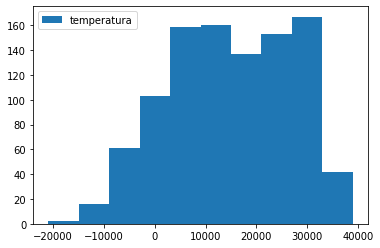

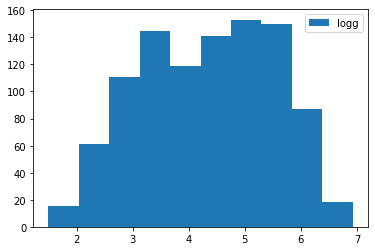

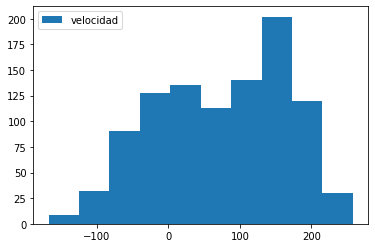

In [48]:
plt.figure()
plt.hist(res0, label="temperatura")
plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_prediccion_temperatura_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()

plt.figure()
plt.hist(res1, label="logg")
plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_prediccion_logg_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()

plt.figure()
plt.hist(res2, label="velocidad")
plt.legend(loc="best")
plt.savefig("../informe1/"+prefijo+"_prediccion_velocidad_e"+str(epochs)+"_l"+str(nlayers)+".png",dpi='figure') #save as png
plt.show()

text_file.close()